<a href="https://colab.research.google.com/github/ozguurdemir/Neural-Networks/blob/main/CureThePrincessRegularizated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

Device: cuda
Test Accuracy: 49.74 %
Epoch  0 Training loss 0.8164012672987626 Validation Loss : 0.8158510816838457
Test Accuracy: 49.74 %
Epoch  1 Training loss 0.8158510705658809 Validation Loss : 0.8158510421533041
Test Accuracy: 49.74 %
Epoch  2 Training loss 0.8158510240866113 Validation Loss : 0.8158509969093639
Test Accuracy: 49.74 %
Epoch  3 Training loss 0.8158509854825667 Validation Loss : 0.8158509561434929
Test Accuracy: 49.74 %
Epoch  4 Training loss 0.8158509373047191 Validation Loss : 0.815850904259657
Test Accuracy: 49.74 %
Epoch  5 Training loss 0.8158508895901201 Validation Loss : 0.8158508537655668
Test Accuracy: 49.74 %
Epoch  6 Training loss 0.815850837551868 Validation Loss : 0.8158508029626441
Test Accuracy: 49.74 %
Epoch  7 Training loss 0.8158507802634659 Validation Loss : 0.8158507373357684
Test Accuracy: 49.74 %
Epoch  8 Training loss 0.8158507172616652 Validation Loss : 0.815850676341378
Test Accuracy: 49.74 %
Epoch  9 Training loss 0.8158506528701189 Validat

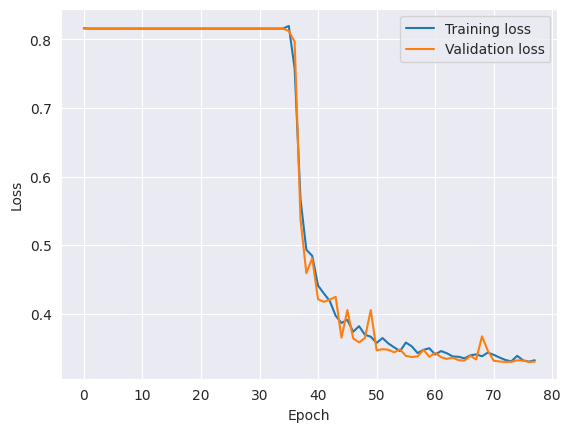

Toplam süre: 25.13703441619873
toplam süre GPU:  298.7311706542969


In [22]:
start_time = time.time()
device = torch.device("cuda")
print("Device:", device)
# Verileri yükle
trainset = pd.read_csv("cure_the_princess_test.csv")
x = trainset.drop(["Cured"], axis=1)
y = trainset["Cured"]
x_tensor = torch.tensor(x.values).float()
y_tensor = torch.tensor(y.values).long()
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)

# DataLoader'ı oluştur
dataset = TensorDataset(x_tensor, y_tensor)
batch_size = 4
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Modeli tanımla
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, num_classes)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        hidden_res1 = self.activation(self.hidden_layer1(x))
        hidden_res1 = self.dropout1(hidden_res1)
        hidden_res2 = self.activation(self.hidden_layer2(hidden_res1))
        hidden_res2 = self.dropout2(hidden_res2)
        output = self.softmax(self.output_layer(hidden_res2))
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)**2
        return output

# MLP modelinin oluşturulması

input_size = x.shape[1]
hidden_size1 = 900
hidden_size2 = 500
num_classes = len(pd.unique(y))
model = MLP(input_size, hidden_size1, hidden_size2, num_classes).to(device)
torch.manual_seed(190401013)
list_train_loss, list_val_loss = [], []
best_val_loss = None
patience = 5
patience_counter = 0
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Eğitim döngüsü
num_epochs = 99999
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
for epoch in range(num_epochs):
    start_event.record()
    train_loss = 0.0
    train_count = 0.0
    for i, (inputs, labels) in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_count += 1.0
        train_loss += loss.item()
        # İlerleme çıktısı
        #if (i+1) % 10 == 0:
           # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(loader), loss.item()))
    val_loss = 0.0
# Modelin doğruluğunun değerlendirilmesi
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        
        for inputs, labels in loader:
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    
    
    train_loss /= train_count
    val_loss /= len(loader)

    val_score = val_loss
    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)
    print('Test Accuracy: {:.2f} %'.format(100 * correct / total))
    print("Epoch ",epoch, "Training loss", train_loss,"Validation Loss :",val_loss)
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0
    end_event.record()
    torch.cuda.synchronize()
    elapsed_time_ms = start_event.elapsed_time(end_event)

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Training loss")
plt.plot(list_val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
end_time = time.time()
total_time = end_time - start_time
print("Toplam süre:", total_time)
print("toplam süre GPU: ", elapsed_time_ms)